# Descriptive Analysis

In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import folium.plugins as plugins


In [2]:
# Note: This parses the colum "ts_start_hour" into Timestamp, so this column will not be strings anymore
# feel free to add additional columns when needed
parse_dates = ['ts_start_hour']
bike_data = pd.read_csv("data/sf_2019_prepared.csv", parse_dates=parse_dates, date_parser=pd.to_datetime)
weather_data =  pd.read_csv("data/weather_hourly_sf_prepared.csv")

In [3]:
bike_data.head()

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,ts_start_hour,start_hour,start_weekday,start_month,trip_duration,start_station_latitude,start_station_longitude
0,2019-01-31 23:54:39,2019-02-01 00:14:28,34.0,146.0,Father Alfred E Boeddeker Park,30th St at San Jose Ave,5114,Subscriber,2019-01-31 23:00:00,23,3,1,1189.0,37.783988,-122.412408
1,2019-01-31 23:17:06,2019-02-01 00:09:40,29.0,70.0,O'Farrell St at Divisadero St,Central Ave at Fell St,4813,Subscriber,2019-01-31 23:00:00,23,3,1,3154.0,37.782405,-122.439446
2,2019-01-31 23:59:48,2019-02-01 00:05:12,223.0,129.0,16th St Mission BART Station 2,Harrison St at 20th St,1976,Subscriber,2019-01-31 23:00:00,23,3,1,324.0,37.764765,-122.420091
3,2019-01-31 23:59:45,2019-02-01 00:04:18,349.0,60.0,Howard St at Mary St,8th St at Ringold St,263,Subscriber,2019-01-31 23:00:00,23,3,1,273.0,37.781010,-122.405666
4,2019-01-31 23:51:55,2019-02-01 00:01:02,77.0,349.0,11th St at Natoma St,Howard St at Mary St,3035,Subscriber,2019-01-31 23:00:00,23,3,1,547.0,37.773507,-122.416040


In [4]:
aggregated_bike_data_month = bike_data.groupby('start_month').size()
aggregated_bike_data_week = bike_data.groupby('start_weekday').size()
aggregated_bike_data_day = bike_data.groupby('start_hour').size()

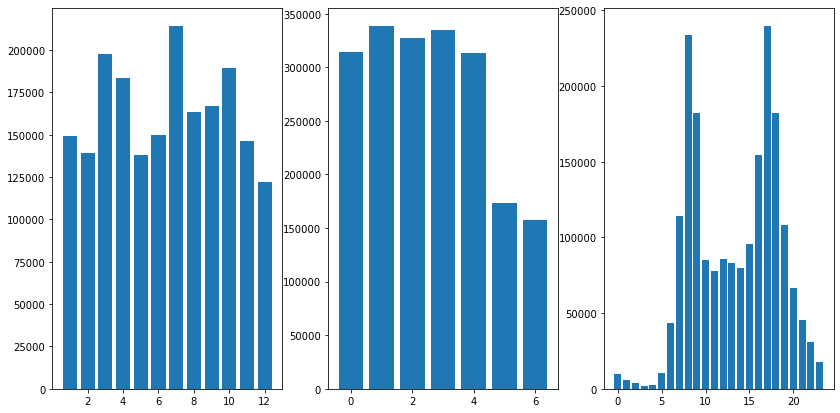

In [5]:
plots_variations, axes_variations = plt.subplots(nrows = 1, ncols = 3, figsize = (14,7))

axes_variations[0].bar(aggregated_bike_data_month.index.values, aggregated_bike_data_month.values)
axes_variations[1].bar(aggregated_bike_data_week.index.values, aggregated_bike_data_week.values)
axes_variations[2].bar(aggregated_bike_data_day.index.values, aggregated_bike_data_day.values)

plt.show()

In [6]:
aggregated_weather_data_month = weather_data.groupby(pd.to_datetime(weather_data.date_time).dt.month).max_temp.mean()
aggregated_weather_data_week  = weather_data.groupby(pd.to_datetime(weather_data.date_time).dt.weekday).max_temp.mean()
aggregated_weather_data_day   = weather_data.groupby(pd.to_datetime(weather_data.date_time).dt.hour).max_temp.mean()

<BarContainer object of 24 artists>

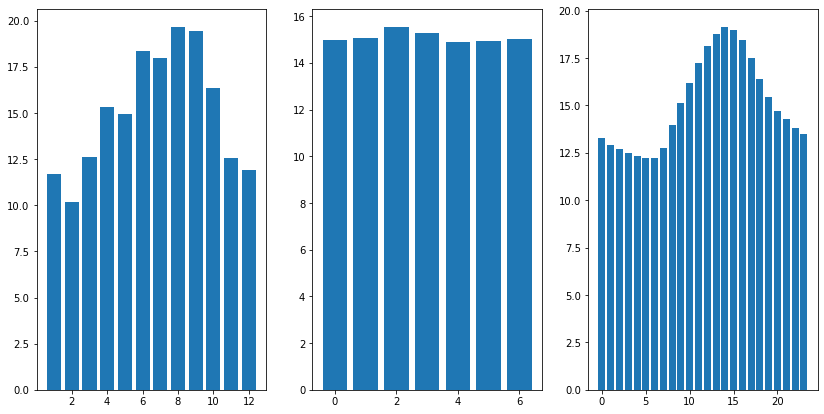

In [7]:
plots_variations, axes_variations = plt.subplots(nrows = 1, ncols = 3, figsize = (14,7))

axes_variations[0].bar(aggregated_weather_data_month.index.values, aggregated_weather_data_month.values)
axes_variations[1].bar(aggregated_weather_data_week.index.values, aggregated_weather_data_week.values)
axes_variations[2].bar(aggregated_weather_data_day.index.values, aggregated_weather_data_day.values) 

In [8]:
# data preparation for the heatmap of weekday and start_hour relationship
# multi-level aggregation through grouping on weekday and start_hour and counting the number of trips per group 
variation_hour_weekday = bike_data.groupby(['start_weekday', 'start_hour'])['start_time'].agg('count')

# because the result of grouping by 2 attributs creates a MultiIndex, we unstack to receive a proper table with counts as values
unstacked_hour_weekday = variation_hour_weekday.unstack(level = 0)

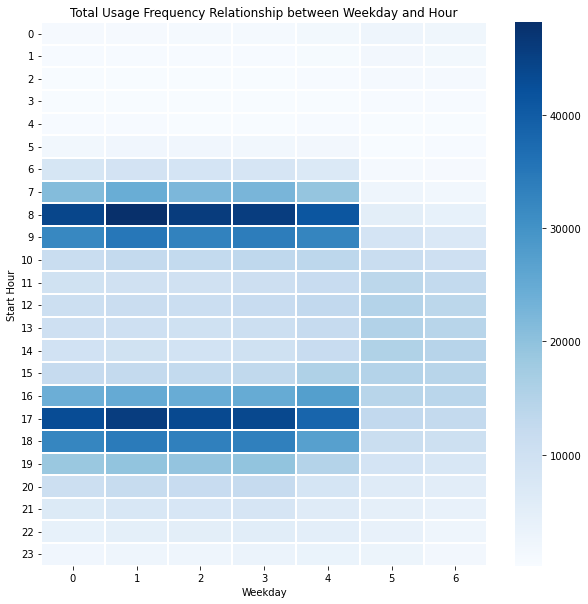

In [9]:
# create seaborn heatmap for the relationship of total usage frequency between weekday and start_hour
week_hours, ax_week_hours = plt.subplots(figsize = (10,10))

# visualization of the heatmap (with labeld and rotated weekend labels on y-axis)
sns.heatmap(unstacked_hour_weekday, cmap = "Blues", linewidth = 0.1, ax = ax_week_hours)

plt.title('Total Usage Frequency Relationship between Weekday and Hour')
plt.xlabel('Weekday')
plt.ylabel('Start Hour')
plt.yticks(rotation=0)

plt.show()

## Geo analysis

Prepare geo_data for visualization. Trips without station_ids are dropped since mandatory geo coordinates are missing.

In [10]:
geo_data = bike_data.dropna().copy()

Function to get list of station data as preparation for the heatmap 

In [11]:
def get_map_aggregation(geo_data, groupAttr):
    geo_data_agg = geo_data[[groupAttr,'start_station_latitude','start_station_longitude', 'start_time']].groupby([groupAttr,'start_station_latitude','start_station_longitude']).count()
    geo_data_agg.reset_index(inplace=True)
    geo_data_agg.rename(columns={'start_time':'cnt'}, inplace=True)

    geo_agg_list = []
    for m in geo_data_agg[groupAttr].unique():
        mon_list = []
        for lat, lon, cnt in zip(geo_data_agg[geo_data_agg[groupAttr] == m].start_station_latitude.values, geo_data_agg[geo_data_agg[groupAttr] == m].start_station_longitude.values,geo_data_agg[geo_data_agg[groupAttr] == m].cnt.values):
            mon_list.append([lat,lon,cnt])
        geo_agg_list.append(mon_list)
    return geo_agg_list

### Heatmap of the monthly bike demand

In [12]:
containers_map_month = folium.Map(location=[37.733795, -122.446747],control_scale = True, zoom_start=12)

plugins.HeatMapWithTime(get_map_aggregation(geo_data=geo_data, groupAttr='start_month'), radius = 10,
                        gradient = {0.1: 'blue', 0.25: 'green', 0.5: 'yellow', 0.75: 'orange', 1: 'red'},
               auto_play = True, min_opacity = 0.5, max_opacity = 1, use_local_extrema = True).add_to(containers_map_month)

containers_map_month

The heat map of monthly bike demand per station does not show a clear seasonal pattern. No pattern can be identified. It is noticeable that stations are added in the outer areas during the course of the year.

### Heatmap of the demand on every weekday

In [13]:
containers_map_day = folium.Map(location=[37.733795, -122.446747],control_scale = True, zoom_start=12)

plugins.HeatMapWithTime(get_map_aggregation(geo_data=geo_data, groupAttr='start_weekday'), radius = 10,
                        gradient = {0.1: 'blue', 0.25: 'green', 0.5: 'yellow', 0.75: 'orange', 1: 'red'},
               auto_play = True, min_opacity = 0.5, max_opacity = 1, use_local_extrema = True).add_to(containers_map_day)

containers_map_day

### Heatmap of the hourly demand

In [14]:
containers_map_hour = folium.Map(location=[37.733795, -122.446747],control_scale = True, zoom_start=12)

plugins.HeatMapWithTime(get_map_aggregation(geo_data=geo_data, groupAttr='start_hour'), radius = 10,
                        gradient = {0.1: 'blue', 0.25: 'green', 0.5: 'yellow', 0.75: 'orange', 1: 'red'},
               auto_play = True, min_opacity = 0.5, max_opacity = 1, use_local_extrema = True).add_to(containers_map_hour)

containers_map_hour

# KPIs
## Comparison between Subscribers and Non-Subscribers
What amount of a timespan is a bike driven by a subscriber in comparison to a non subscriber?   

In [15]:
bike_data.head()

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,ts_start_hour,start_hour,start_weekday,start_month,trip_duration,start_station_latitude,start_station_longitude
0,2019-01-31 23:54:39,2019-02-01 00:14:28,34.0,146.0,Father Alfred E Boeddeker Park,30th St at San Jose Ave,5114,Subscriber,2019-01-31 23:00:00,23,3,1,1189.0,37.783988,-122.412408
1,2019-01-31 23:17:06,2019-02-01 00:09:40,29.0,70.0,O'Farrell St at Divisadero St,Central Ave at Fell St,4813,Subscriber,2019-01-31 23:00:00,23,3,1,3154.0,37.782405,-122.439446
2,2019-01-31 23:59:48,2019-02-01 00:05:12,223.0,129.0,16th St Mission BART Station 2,Harrison St at 20th St,1976,Subscriber,2019-01-31 23:00:00,23,3,1,324.0,37.764765,-122.420091
3,2019-01-31 23:59:45,2019-02-01 00:04:18,349.0,60.0,Howard St at Mary St,8th St at Ringold St,263,Subscriber,2019-01-31 23:00:00,23,3,1,273.0,37.781010,-122.405666
4,2019-01-31 23:51:55,2019-02-01 00:01:02,77.0,349.0,11th St at Natoma St,Howard St at Mary St,3035,Subscriber,2019-01-31 23:00:00,23,3,1,547.0,37.773507,-122.416040


In [16]:
# as above this returns a multi-index dataframe
grouped_user_types_per_hour = bike_data.groupby(["ts_start_hour", "user_type"]).size()  

# we unstack this dataframe into a table with two colums "Subscriber" and "Customer"
subscriber_customer_counts =  grouped_user_types_per_hour.unstack(level=0, fill_value=0).transpose()    

subscribers_percentage = subscriber_customer_counts["Subscriber"] / (subscriber_customer_counts["Subscriber"] + subscriber_customer_counts["Customer"])
subscribers_percentage.head(n=15)

ts_start_hour
2019-01-01 00:00:00    0.568966
2019-01-01 01:00:00    0.633803
2019-01-01 02:00:00    0.542857
2019-01-01 03:00:00    0.777778
2019-01-01 04:00:00    0.750000
2019-01-01 05:00:00    1.000000
2019-01-01 06:00:00    0.777778
2019-01-01 07:00:00    0.812500
2019-01-01 08:00:00    0.833333
2019-01-01 09:00:00    0.912281
2019-01-01 10:00:00    0.738095
2019-01-01 11:00:00    0.653543
2019-01-01 12:00:00    0.595890
2019-01-01 13:00:00    0.524324
2019-01-01 14:00:00    0.617450
dtype: float64

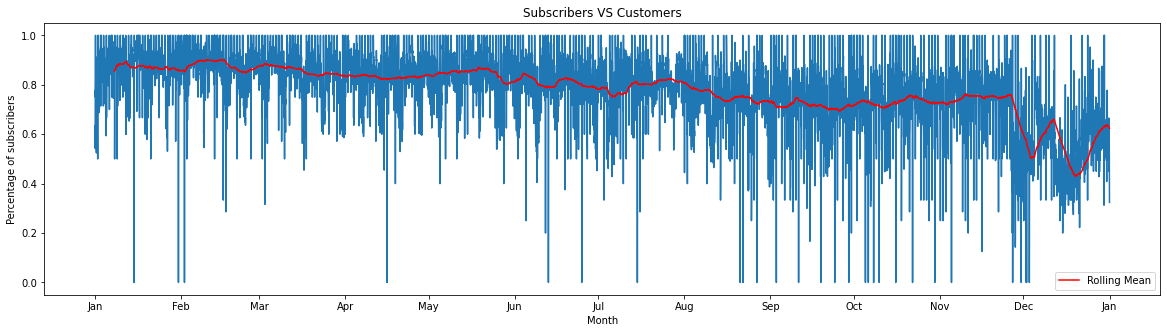

In [17]:
# For this timeseries we show a lot of hourly values with a large variance over a day
# For easier interpretation we add a plot of the rolling average with a window of one week 
rolmean = subscribers_percentage.rolling(window=24*7).mean()


plot, axis =  plt.subplots(nrows = 1, ncols = 1, figsize = (20,5))
axis.plot(subscribers_percentage.index.values, subscribers_percentage.values)
axis.plot(rolmean, color='red', label='Rolling Mean')
axis.legend(loc='best')
axis.set_title('Subscribers VS Customers')
axis.set_ylabel('Percentage of subscribers')
axis.set_xlabel('Month')

# Uses special matplotlib locators to specify where the label should appear:
# https://matplotlib.org/stable/api/dates_api.html 
axis.xaxis.set_major_locator(mpl.dates.MonthLocator(interval=1))
# also uses a DateFormatter to convert the timestamp to a formatted string (that only contains the month
axis.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b'))

plt.show()

## Necessary relocations of a bike
How often is it necessary to reposition a bike in a given time interval (i.e. the bike has a different start station than the last end station?

In [ ]:
# Note: this takes a long time to recalculate, because it iterates over the whole dataset (about 10 - 15 minutes)
# DO NOT EXECUTE UNLESS ABSOLUTELY NECESSARY

# First group all trips by bike_id, as we need the relocations per bike
trips_per_bike = bike_data.groupby("bike_id")

# This dataframe will contain the number of relocations by hour
# We have to create if first using a datetime range from begin to end of 2019, ...
# because we can have hours that don't have a single relocations
relocations_df = pd.DataFrame(data=0, index =pd.date_range(start="2019-01-01", end="2020-01-01", freq='H', normalize = True), columns=["relocations"])


for name, group in trips_per_bike:
    # sort group by start time
    sorted_group = group.sort_values(ascending=True, by="start_time")

    indices = sorted_group.index
    for idx in range(0,len(indices)):
        # Now always try to get pairs of two following trips of each bike 
        current_row = sorted_group.loc[indices[idx]]
        try:
            next_row = sorted_group.loc[indices[idx + 1]]
        except IndexError:
            # If we are at the end of the indices, skip this check and continue with the next bike id
            continue

        # Check if the current end station is different from the next start station
        # In those cases we can assume, that a relocation that was not paid by customers/ subscribers took place
        if (current_row.end_station_id != next_row.start_station_id):
            # Some sort of progress indicator
            # Goes until 999_941, but in the end the trips are much more sparse (most are below 9000)
            print(f"Current trip id: {current_row.bike_id}") 
            
            # Additional debug output if nessecary
            # print(f"Current Trip ID \n {current_row} \n Next Trip ID \n{next_row}")
            # print(f"Current End Station {current_row.end_station_id} Next Start Station {next_row.start_station_id}" )

            # increase the counter for the start hour of the next trip by one
            timestamp = next_row.ts_start_hour
            relocations_df.loc[timestamp][0] =relocations_df.loc[timestamp][0] + 1

            # more debug output
            # print(str(relocations_df.loc[timestamp][0]) +f" at {timestamp}") 


In [72]:
# Some statistics about relocations
print(f"Average relocations {relocations_df.mean()}")

Average relocations relocations    38.158087
dtype: float64


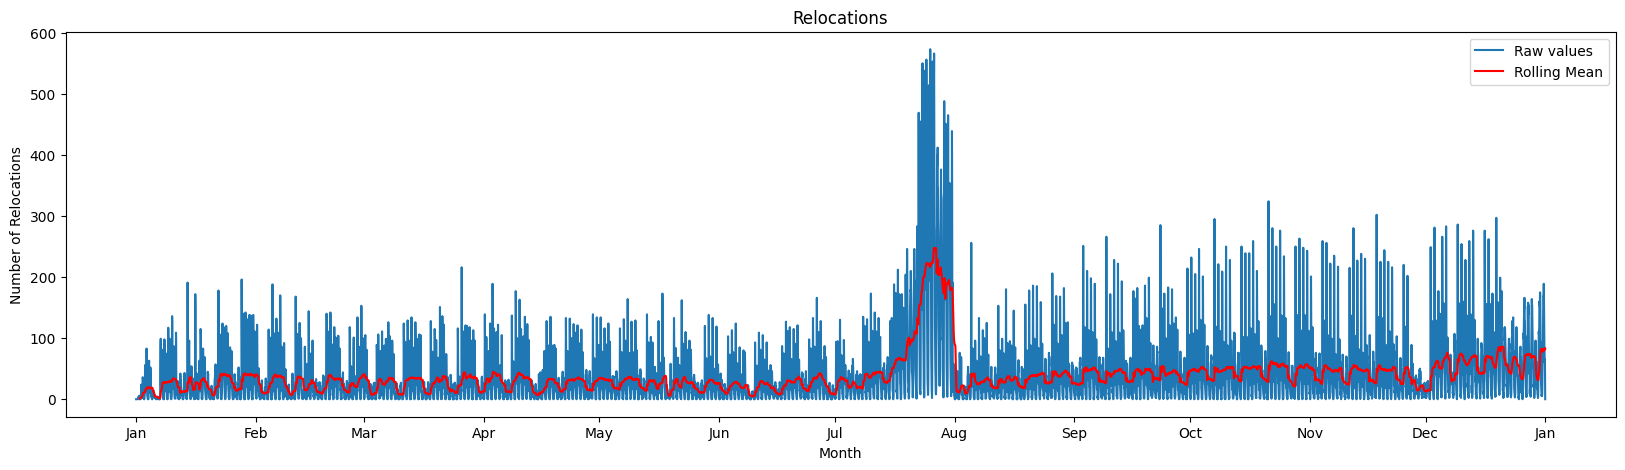

In [80]:
# For this timeseries we show a lot of hourly values with a large variance over a day
# For easier interpretation we add a plot of the rolling average with a window of 24 hours 
rolmean = relocations_df.rolling(window=24).mean()

plot, axis =  plt.subplots(nrows = 1, ncols = 1, figsize = (20,5))
axis.plot(relocations_df, label="Raw values")
axis.plot(rolmean, color='red', label='Rolling Mean')
axis.legend(loc='best')
axis.set_title('Relocations')
axis.set_ylabel('Number of Relocations')
axis.set_xlabel('Month')

# Uses special matplotlib locators to specify where the label should appear:
# https://matplotlib.org/stable/api/dates_api.html 
axis.xaxis.set_major_locator(mpl.dates.MonthLocator(interval=1))
# also uses a DateFormatter to convert the timestamp to a formatted string (that only contains the month
axis.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b'))

plt.show()

As we can see, we have a about 40 relocations per hour (on average) with a high spike in late july.

## Bike demand
Calculate the number of trips per hour

In [18]:
demand = bike_data.groupby([pd.DatetimeIndex(bike_data['ts_start_hour'])]).agg({'start_time': 'count'})

demand

,start_time
ts_start_hour,
2019-01-01 00:00:00,58
2019-01-01 01:00:00,71
2019-01-01 02:00:00,35
2019-01-01 03:00:00,9
2019-01-01 04:00:00,4
...,...
2019-12-31 19:00:00,167
2019-12-31 20:00:00,147
2019-12-31 21:00:00,96


In [19]:
demand.describe()

,start_time
count,8744.000000
mean,224.190645
std,247.485749
min,1.000000
25%,33.000000
50%,163.000000
75%,284.000000
max,1493.000000


The hourly demand ranges between 1 and 1569 rides. In average number of bike rides is 242.21. 

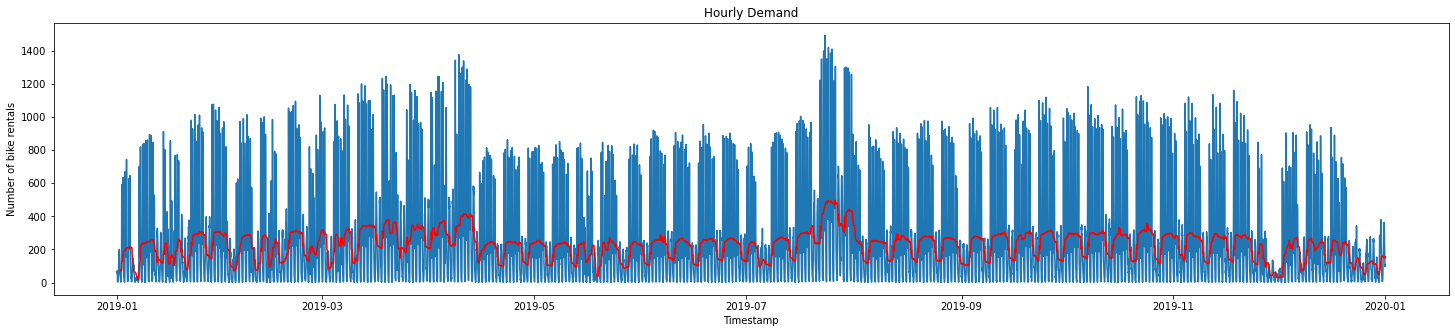

In [20]:
plot, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (25,5))
rolmean = demand.rolling(window=24).mean()
axes.plot(demand)
axes.plot(rolmean, color='red', label='Rolling Mean')
axes.set_title('Hourly Demand')
axes.set_xlabel('Timestamp')
axes.set_ylabel('Number of bike rentals')
plt.show()

## Bike utilization
Calculate the number of bikes in use and compare this with the number of trips taken in a certain hour.

In [21]:
# It is sufficient to just group the values over our new ts_start_hour column and aggregate the unique values of bike_ids
bikes_used = bike_data.groupby([pd.DatetimeIndex(bike_data['ts_start_hour'])]).agg({'bike_id' : 'nunique'})

# Ensure that we don't have to many hours missing  (could happen when no bike was in use), so that the graph could get distorted
print(f"Number of hours per day: {bikes_used.size/365}.")

Number of hours per day: 23.956164383561642.


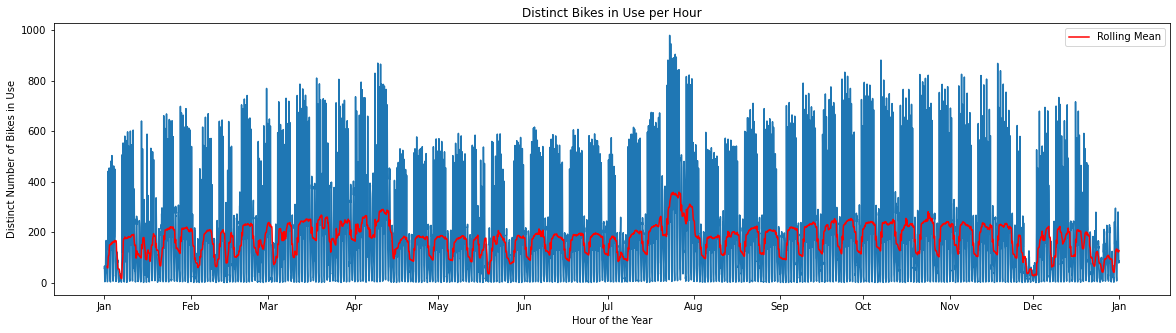

In [22]:
# For this timeseries we show a lot of hourly values with a large variance over a day
# For easier interpretation we add a plot of the rolling average with a window of 24 hours 
rolmean = bikes_used.rolling(window=24).mean()

# visualize the hourly bike usage
plot, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (20,5))

axes.plot(bikes_used)
axes.axis('tight')
axes.plot(rolmean, color='red', label='Rolling Mean')
axes.legend(loc='best')
axes.set_title('Distinct Bikes in Use per Hour')
axes.set_xlabel('Hour of the Year')
axes.set_ylabel('Distinct Number of Bikes in Use')



# Uses special matplotlib locators to specify where the label should appear:
# https://matplotlib.org/stable/api/dates_api.html 
axes.xaxis.set_major_locator(mpl.dates.MonthLocator(interval=1))
# also uses a DateFormatter to convert the timestamp to a formatted string (that only contains the month
axes.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b'))

You can clearly see the weekly spikes (about 4 per month) in bike usage which is mostly due to working days.

In [23]:
trips_taken = bike_data.groupby([pd.DatetimeIndex(bike_data['ts_start_hour'])]).agg({'start_time' : 'count'})

# calculate the ratios
ratio = bikes_used.bike_id  / trips_taken.start_time

For better visualization we only plot the first 500 hours in the year 2019, because otherwise the graph gets quite confusing.

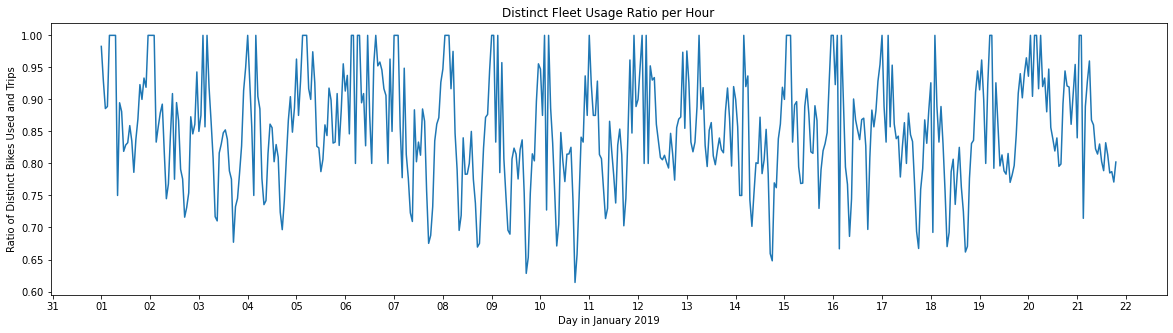

In [24]:
# visualize
plt_ratio, axes_ratio = plt.subplots(nrows = 1, ncols = 1, figsize = (20,5))

axes_ratio.plot(ratio[:500])
axes_ratio.axis('tight')
axes_ratio.set_title('Distinct Fleet Usage Ratio per Hour')
axes_ratio.set_xlabel('Day in January 2019')
axes_ratio.set_ylabel('Ratio of Distinct Bikes Used and Trips')


# Uses special matplotlib locators to specify where the label should appear:
# https://matplotlib.org/stable/api/dates_api.html 
axes_ratio.xaxis.set_major_locator(mpl.dates.DayLocator(interval=1))
# also uses a DateFormatter to convert the timestamp to a formatted string (that only contains the month
axes_ratio.xaxis.set_major_formatter(mpl.dates.DateFormatter('%d'))

plt.show()

# Note: values near to 1 mean that in this hour the number of bikes used and trips taken is almost identical
# This would indicate a good distribution of the bikes
# Values near to 0 mean that only very few bikes are used for almost all trips, so many bikes are not in use
# This would indicate a bad distribution of the bikes

## Revenue
Calculate the hourly revenue. The calculated revenue is based on the assumption that every rental is done by a customer and based on the current pricing model found on the lyft.com website (https://www.lyft.com/bikes/bay-wheels/pricing).    
Calculating the revenue of a subscriber is not possible due to missing subscription ids and therefore no possible distinction of each subscriber.

Pricing model for a customer (single trip):
- 30 min included
- $ 3.49 unlock fee
- $ 0.30 per min after included ride time

In [25]:
unlock_fee = 3.49
cost_per_min = 0.3
min_incl = 30

bike_data['trip_costs'] = bike_data['trip_duration'].map(lambda x:  unlock_fee if x <= 60*min_incl else unlock_fee + (x/60 - min_incl)*cost_per_min)

revenue = bike_data.groupby([pd.DatetimeIndex(bike_data['ts_start_hour'])]).agg({'trip_costs': 'sum'})

revenue

,trip_costs
ts_start_hour,
2019-01-01 00:00:00,213.420
2019-01-01 01:00:00,359.110
2019-01-01 02:00:00,134.250
2019-01-01 03:00:00,50.085
2019-01-01 04:00:00,15.810
...,...
2019-12-31 19:00:00,631.605
2019-12-31 20:00:00,587.220
2019-12-31 21:00:00,368.655


In [26]:
revenue.describe()

,trip_costs
count,8744.000000
mean,832.955292
std,893.986329
min,3.490000
25%,125.640000
50%,603.467500
75%,1126.711250
max,5491.970000


The hourly revenue ranges between \$ 3.49 (= unlock fee) and \$ 5760.1. In average the revenue is \$ 900.15. 

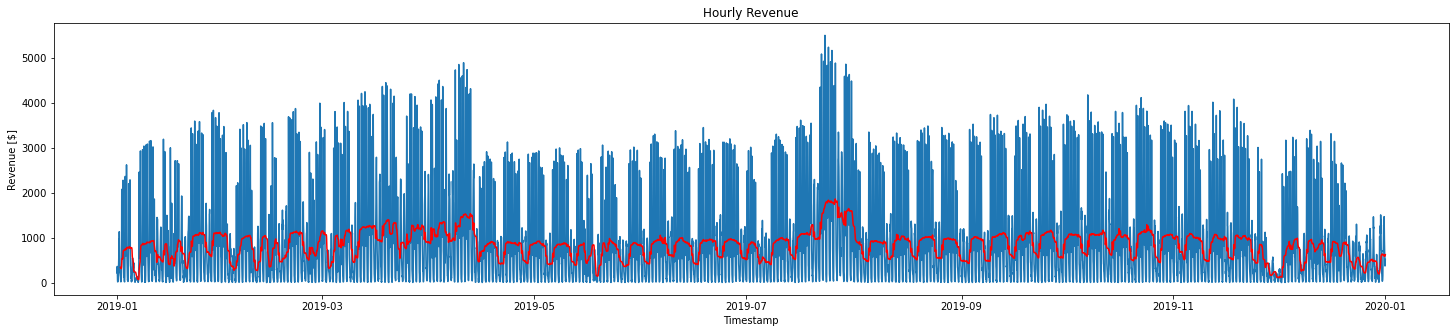

In [27]:
plot, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (25,5))
rolmean = revenue.rolling(window=24).mean()
axes.plot(revenue)
axes.plot(rolmean, color='red', label='Rolling Mean')
axes.set_title('Hourly Revenue')
axes.set_xlabel('Timestamp')
axes.set_ylabel('Revenue [$]')
plt.show()